In [1]:
!pip install tqdm
!pip install pillow --upgrade
!pip install kagglehub
!pip install opencv-python
!pip install pandas
!pip install pillow

In [2]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

import kagglehub
import cv2
import pandas as pd
from PIL import Image

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/07/25 21:45:58] INFO     Found credentials from IAM Role:                                   ]8;id=578938;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=907973;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
root_path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", root_path)

Path to dataset files: /home/ec2-user/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2


In [4]:
data_path = os.listdir(root_path)

In [103]:
dataset_path = os.path.join(root_path, data_path[0])
patients = sorted(os.listdir(dataset_path))

image_paths = []
mask_paths = []

for patient in patients:
    patient_dir = os.path.join(dataset_path, patient)
    if os.path.isdir(patient_dir):
        for file in os.listdir(patient_dir):
            file_path = os.path.join(patient_dir, file)
            if file.endswith(".tif") and "_mask" not in file:
                image_paths.append(file_path)
                mask_file = file.replace(".tif", "_mask.tif")
                mask_path = os.path.join(patient_dir, mask_file)
                if os.path.exists(mask_path):
                    mask_paths.append(mask_path)
                else:
                    mask_paths.append(None)


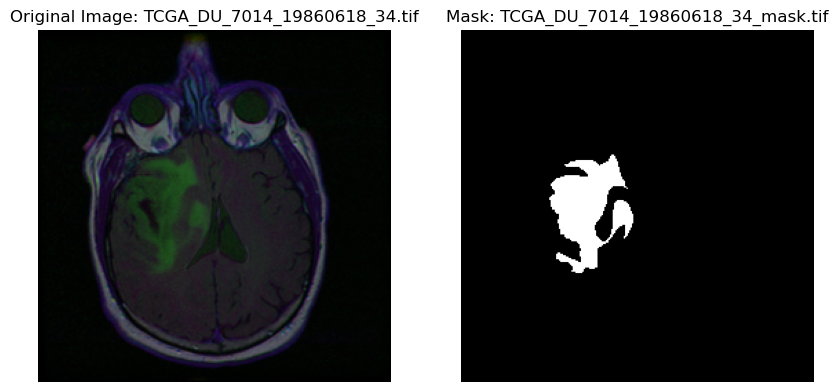

In [105]:
random_idx = random.randint(0, len(image_paths) - 1)
img_path = image_paths[random_idx]
mask_path = mask_paths[random_idx]

img = Image.open(img_path)
mask = Image.open(mask_path) if mask_path else None

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title(f"Original Image: {os.path.basename(img_path)}")
plt.axis("off")

if mask:
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask: {os.path.basename(mask_path)}")
    plt.axis("off")

plt.show()

In [32]:
print(np.unique(mask))

[  0 255]


In [8]:
role = sagemaker.get_execution_role()
bucket_name = 'mri-semantic-segmentation'
training_name = sagemaker.image_uris.retrieve('semantic-segmentation',
                                              boto3.Session().region_name,
                                              version='latest')
print(training_name)


[03/07/25 21:46:01] INFO     Found credentials from IAM Role:                                   ]8;id=252771;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=766375;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=139108;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=290409;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=108927;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=548916;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

825641698319.dkr.ecr.us-east-2.amazonaws.com/semantic-segmentation:1


In [123]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']
for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

In [124]:
def convert_tif_to_jpg(input_tif_path, output_jpg_path):
    # Open the TIFF image
    with Image.open(input_tif_path) as img:
        # Convert to RGB (JPEG format doesn't support alpha channel)
        rgb_img = img.convert("RGB")
        # Save the image as JPEG
        rgb_img.save(output_jpg_path, "JPEG")

def convert_tif_to_png(input_tif_path, output_png_path):
    with Image.open(input_tif_path) as img:
        img.save(output_png_path, "PNG")
        
for idx, image in tqdm(enumerate(image_paths)):
    if image.endswith(".tif"):
        target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
        image_target_path = os.path.join(target_set, os.path.basename(image)[:-3]+"jpeg")
        mask_target_path = os.path.join(target_set + '_annotation', os.path.basename(mask_paths[idx])[:-9]+".png")
        #Convert and save image
        convert_tif_to_jpg(image, image_target_path)
        #Convert and save mask
        convert_tif_to_png(mask_paths[idx], mask_target_path)
        

3929it [00:11, 328.48it/s]


In [126]:
train_images = sorted(os.listdir('train'))
train_annots = sorted(os.listdir('train_annotation'))
print(len(train_images), len(train_annots))

2927 2927


In [127]:
train_images[0], train_annots[0]

('TCGA_CS_4941_19960909_1.jpeg', 'TCGA_CS_4941_19960909_1.png')

In [128]:
sess = sagemaker.Session()
print("starting...")
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print("Train images uploaded!")
s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name, key_prefix='train_annotation')
print("Train annotation images uploaded!")

s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name, key_prefix='validation')
print("Validation images uploaded!")
s3_validation_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name, key_prefix='validation_annotation')
print("Validation annotation images uploaded!")


starting...
Train images uploaded!
Train annotation images uploaded!
Validation images uploaded!
Validation annotation images uploaded!


In [135]:
model = sagemaker.estimator.Estimator(training_name,
                            role=role,
                            train_instance_count=1,
                            train_instance_type="ml.p3.2xlarge",
                            train_volume_size=100,
                            train_max_run=36000,
                            input_model='File',
                            output_path = 's3://mri-semantic-segmentation/output',
                            sagemaker_session=sess)  

[03/08/25 02:21:02] WARNING  train_instance_count has been renamed in sagemaker>=2.              ]8;id=680125;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=909181;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  train_instance_type has been renamed in sagemaker>=2.               ]8;id=239833;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=406817;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  train_max_run has been renamed in sagemaker>=2.                     ]8;id=810871;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=257829;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  train_volume_size has been renamed in sagemaker>=2.                 ]8;id=423698;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=488684;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

In [136]:
model.set_hyperparameters(
    backbone='resnet-50',
    algorithm='fcn',
    use_pretrained_model=True,
    crop_size=240,
    num_classes=2,
    epochs=10,
    learning_rate=0.0001,
    optimizer='rmsprop',
    mini_batch_size=16,
    validation_mini_batch_size=16,
    num_training_samples=len(train_images)
)

In [131]:
train_data = sagemaker.inputs.TrainingInput(s3_train_path,
                                       distribution='FullyReplicated',
                                       content_type='image/jpeg',
                                       s3_data_type='S3Prefix')
validation_data = sagemaker.inputs.TrainingInput(s3_validation_path,
                                       distribution='FullyReplicated',
                                       content_type='image/jpeg',
                                       s3_data_type='S3Prefix')

train_annotation_data = sagemaker.inputs.TrainingInput(s3_train_annotation_path,
                                       distribution='FullyReplicated',
                                       content_type='image/png',
                                       s3_data_type='S3Prefix')

validation_annotation_data = sagemaker.inputs.TrainingInput(s3_validation_annotation_path,
                                       distribution='FullyReplicated',
                                       content_type='image/png',
                                       s3_data_type='S3Prefix')

In [132]:
data_channels = {'train': train_data,
                'validation': validation_data,
                'train_annotation': train_annotation_data,
                'validation_annotation': validation_annotation_data
               }

In [133]:
data_channels

{'train': <sagemaker.inputs.TrainingInput at 0x7fc9e21844f0>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7fc9e2187e80>,
 'train_annotation': <sagemaker.inputs.TrainingInput at 0x7fc9e2184cd0>,
 'validation_annotation': <sagemaker.inputs.TrainingInput at 0x7fc9e2186500>}

In [134]:
model.fit(inputs=data_channels, logs=True)

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=420169;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=848833;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=832387;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=866337;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             semantic-segmentation-2025-03-08-02-02-03-413                                         

2025-03-08 02:02:04 Starting - Starting the training job...
..25-03-08 02:02:28 Starting - Preparing the instances for training.
.....03-08 02:02:58 Downloading - Downloading input data.
.......................nloading - Downloading the training image.
Docker entrypoint called with argument(s): trainmpleted. Training in progress..
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sat Mar  8 02:08:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                   